<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_week5_featureengineering_ensemblelearning_crossvalidation_healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# INFO 371: Week 5 Topics - Feature Engineering, Ensemble Learning, Cross Validation (Healthcare Version)

# 0. Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Generate a Realistic Healthcare Dataset
np.random.seed(42)
patients = ['Patient_' + str(i) for i in range(1, 201)]  # 200 patients
data = []

for date in pd.date_range(start='2023-01-01', periods=500):
    patient_id = np.random.choice(patients)
    systolic_bp = np.random.normal(120, 15)
    diastolic_bp = np.random.normal(80, 10)
    heart_rate = np.random.normal(75, 12)
    prior_visits = np.random.poisson(2)
    admitted = np.random.binomial(1, p=0.3 + 0.01 * (systolic_bp > 140))  # More likely if high BP
    data.append([date, patient_id, systolic_bp, diastolic_bp, heart_rate, prior_visits, admitted])

records = pd.DataFrame(data, columns=['Date', 'PatientID', 'SystolicBP', 'DiastolicBP', 'HeartRate', 'PriorVisits', 'Admitted'])
records.sort_values('Date', inplace=True)

In [4]:
# 2. Create Rolling Features (Mini Feature Engineering)
records['AvgSystolicBP'] = records.groupby('PatientID')['SystolicBP'].transform(lambda x: x.rolling(5, min_periods=1).mean())
records['AvgDiastolicBP'] = records.groupby('PatientID')['DiastolicBP'].transform(lambda x: x.rolling(5, min_periods=1).mean())
records['AvgHeartRate'] = records.groupby('PatientID')['HeartRate'].transform(lambda x: x.rolling(5, min_periods=1).mean())
records['VisitFrequency'] = records.groupby('PatientID').cumcount()


In [6]:
# 3. Feature and Label Selection
features = records[['AvgSystolicBP', 'AvgDiastolicBP', 'AvgHeartRate', 'PriorVisits', 'VisitFrequency']]
labels = records['Admitted']

In [7]:
# 4. Class Weights to Balance
class_weights = dict(zip(np.unique(labels), compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)))

In [8]:
# 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [10]:
# 6. Models
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

# Random Forest (Balanced)
rf = RandomForestClassifier(n_estimators=100, max_features=2, random_state=42, class_weight=class_weights)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

KNN Accuracy: 0.67
Random Forest Accuracy: 0.66


In [11]:
# 7. Bias-Variance Tradeoff Comment
print("""
- KNN can have high variance if too sensitive to outliers.
- Random Forest reduces variance by averaging trees.
- Best models minimize both bias (wrong assumptions) and variance (overfitting).
""")



- KNN can have high variance if too sensitive to outliers.
- Random Forest reduces variance by averaging trees.
- Best models minimize both bias (wrong assumptions) and variance (overfitting).



In [12]:
# 8. Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf, features, labels, cv=kfold)
print("Random Forest KFold CV Accuracy:", np.mean(rf_cv_scores))

loo = LeaveOneOut()
small_features = features.sample(50, random_state=42)
small_labels = labels.loc[small_features.index]
loo_scores = cross_val_score(knn, small_features, small_labels, cv=loo)
print("KNN LOO CV Accuracy (subset):", np.mean(loo_scores))

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = cross_val_score(rf, features, labels, cv=skfold)
print("Random Forest StratifiedKFold CV Accuracy:", np.mean(stratified_scores))

Random Forest KFold CV Accuracy: 0.698
KNN LOO CV Accuracy (subset): 0.68
Random Forest StratifiedKFold CV Accuracy: 0.7179999999999999


In [13]:
# 9. Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [1, 2, 3]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight=class_weights), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)
final_model = grid_search.best_estimator_
final_preds = final_model.predict(X_test)
print("Final Model Accuracy after Grid Search:", accuracy_score(y_test, final_preds))

Best Parameters from Grid Search: {'max_features': 1, 'n_estimators': 50}
Final Model Accuracy after Grid Search: 0.68


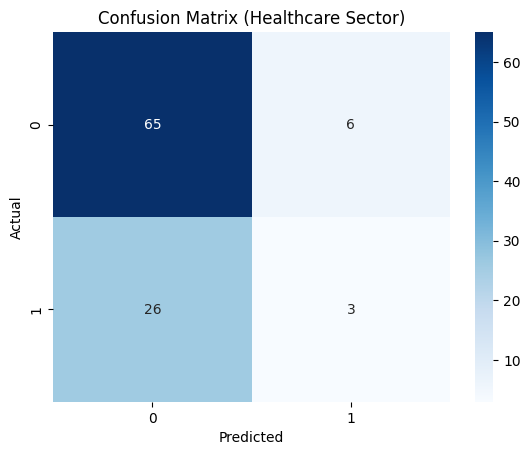

In [14]:
# 10. Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Healthcare Sector)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()